## Performance analyse of PET with different values of D_PET and N_GNN

This notebook analyzes the performance of PET varing the values of such hyperparameters as `N_GNN` and `D_PET` (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) with the focus on evaluating the mean absolute error (MAE) and interference times.

In [73]:
from matplotlib import pyplot as plt
import os
import re
import numpy as np
import pickle

Helper functions

In [74]:
def sort_key(name):
    """
    Sorts folder names based on numeric values within the names
    """
    return [int(text) if text.isdigit() else text for text in re.split(r"(\d+)", name)]

In [75]:
def get_best_maes(folders, keys):
    """
    Extract the value of best MAE from the summary.txt
    """
    target_phrase = "best val mae in energies per structure:"
    best_maes = {}

    for index, folder in enumerate(folders):
        path = os.path.join(folder, "results")
        attempts = sorted(os.listdir(path), key=sort_key)

        if not attempts:
            print(f"No result folders found in {path}")
            continue

        last_folder = attempts[-1]
        summary_file_path = os.path.join(path, last_folder, "summary.txt")

        if not os.path.isfile(summary_file_path):
            print(f"File {summary_file_path} not found")
            continue

        with open(summary_file_path, "r") as file:
            for line in file:
                if target_phrase in line:
                    best_maes[str(keys[index])] = float(
                        line.split(target_phrase)[-1].split()[0]
                    )

    return best_maes

### MAE vs Number of GNN Layers

MAE is analysed against the number of GNN layers with a fixed dimensionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET

In [76]:
def plot(x_values, y_values, title, xlabel, ylabel):
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_values, y_values, "bo-")

    for x, y in zip(list(x_values), list(y_values)):
        plt.annotate(
            f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center"
        )

    # plt.yscale('log')
    plt.grid(True)

#### D_PET = 32

In [77]:
FOLDERS = ["run_1_32", "run_2_32", "run_3_32"]
N_GNNs = [1, 2, 3]

best_maes = get_best_maes(folders=FOLDERS, keys=N_GNNs)

In [78]:
x_values = list(best_maes.keys())
y_values = list(best_maes.values())

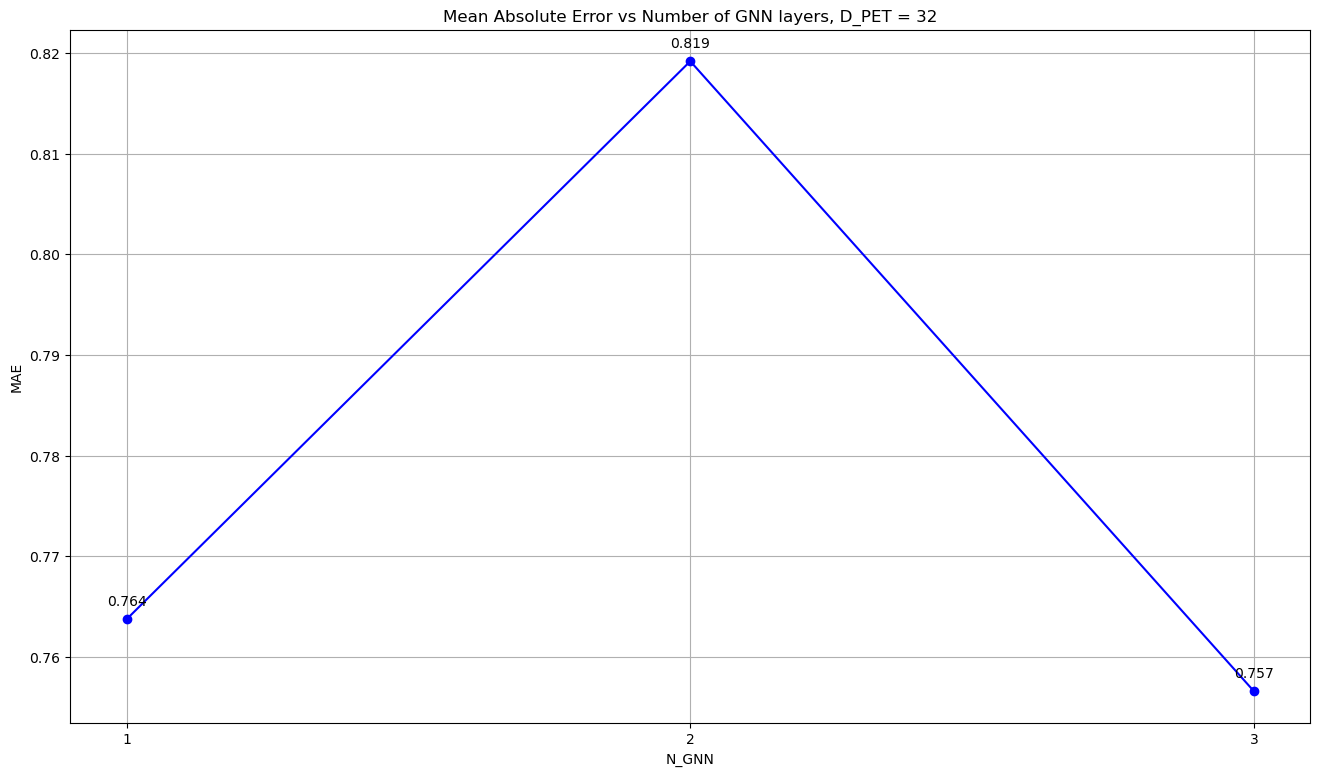

In [79]:
plot(
    x_values,
    y_values,
    title="Mean Absolute Error vs Number of GNN layers, D_PET = 32",
    xlabel="N_GNN",
    ylabel="MAE",
)

#### D_PET = 64

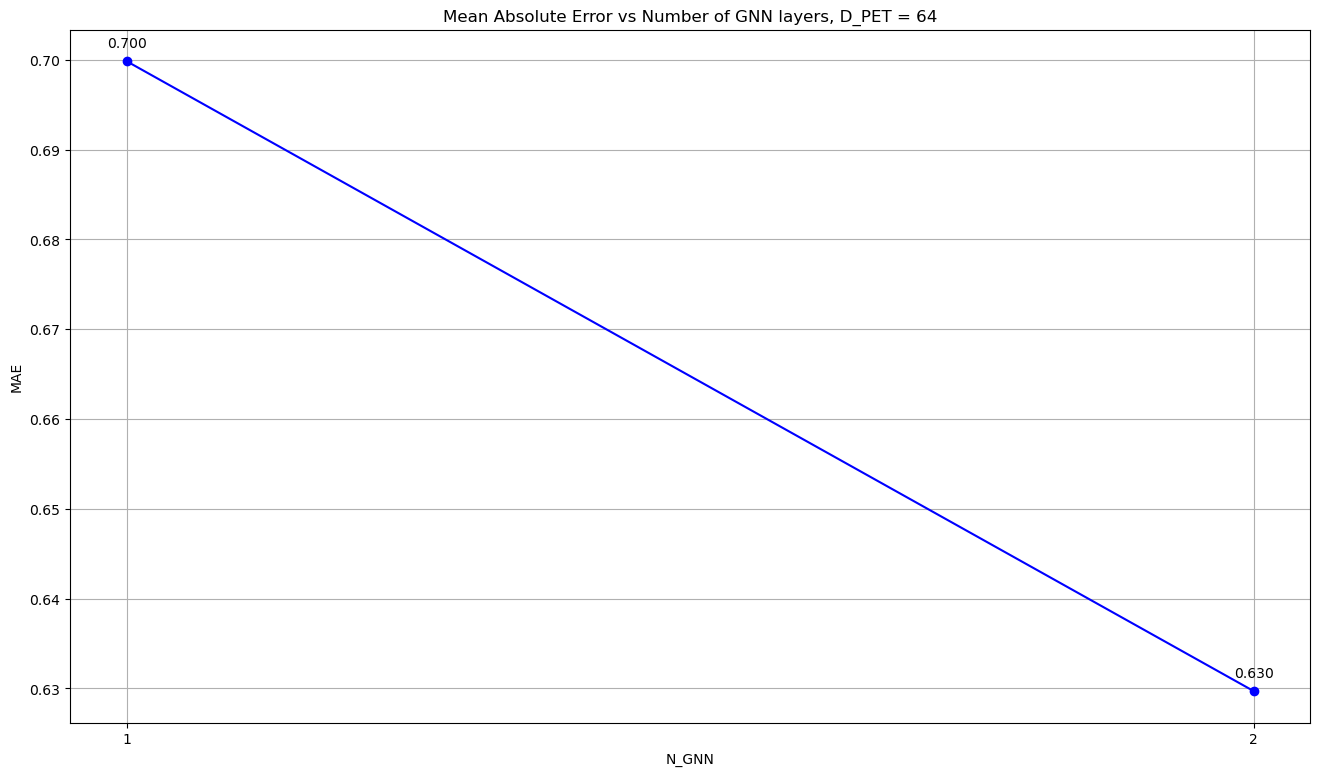

In [80]:
FOLDERS = ["run_1_64", "run_2_64"]
N_GNNs = [1, 2]

best_maes = get_best_maes(folders=FOLDERS, keys=N_GNNs)

x_values = list(best_maes.keys())
y_values = list(best_maes.values())

plot(
    x_values,
    y_values,
    title="Mean Absolute Error vs Number of GNN layers, D_PET = 64",
    xlabel="N_GNN",
    ylabel="MAE",
)

### MAE vs D_PET

MAE is analysed against the dimentionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET with a fixed number of GNN layers

#### N_GNN = 1

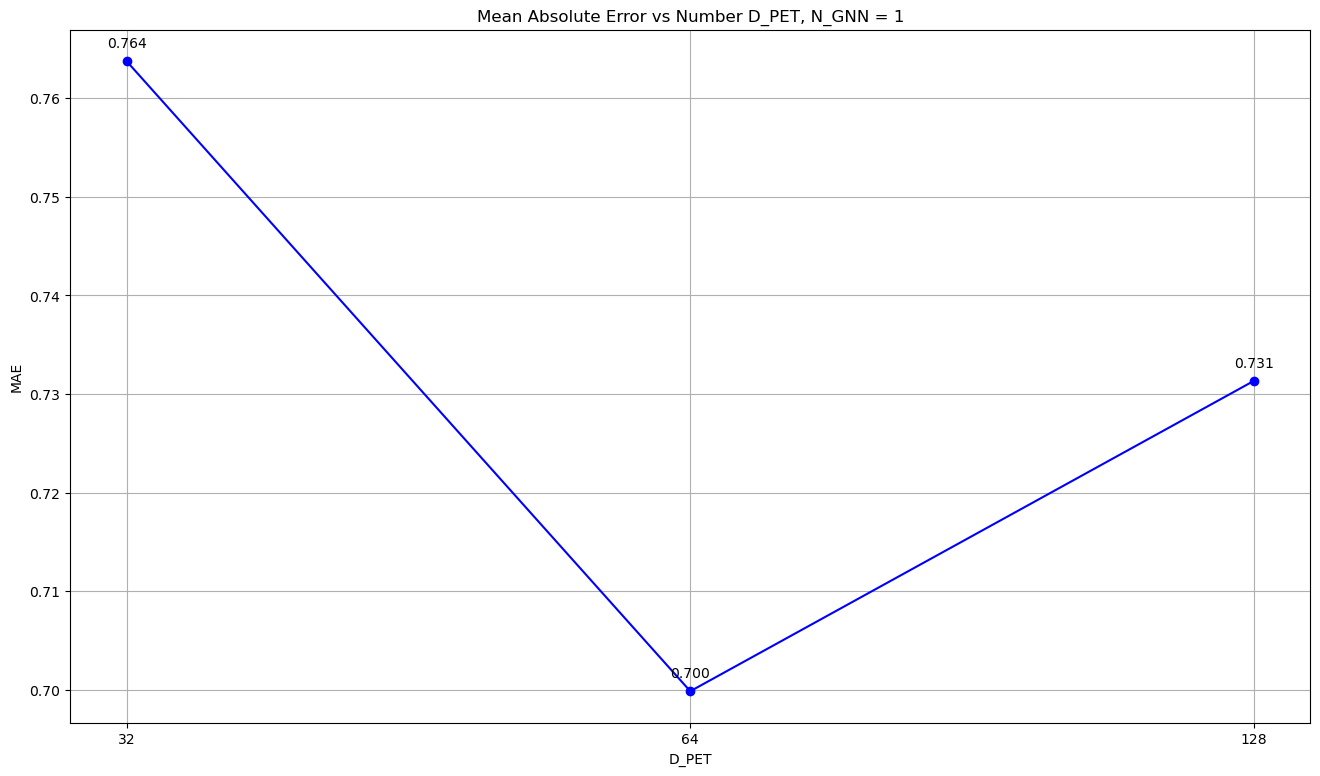

In [81]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128"]
D_PET = [32, 64, 128]

best_maes = get_best_maes(folders=FOLDERS, keys=D_PET)

x_values = list(best_maes.keys())
y_values = list(best_maes.values())

plot(
    x_values,
    y_values,
    title="Mean Absolute Error vs Number D_PET, N_GNN = 1",
    xlabel="D_PET",
    ylabel="MAE",
)

#### N_GNN = 2

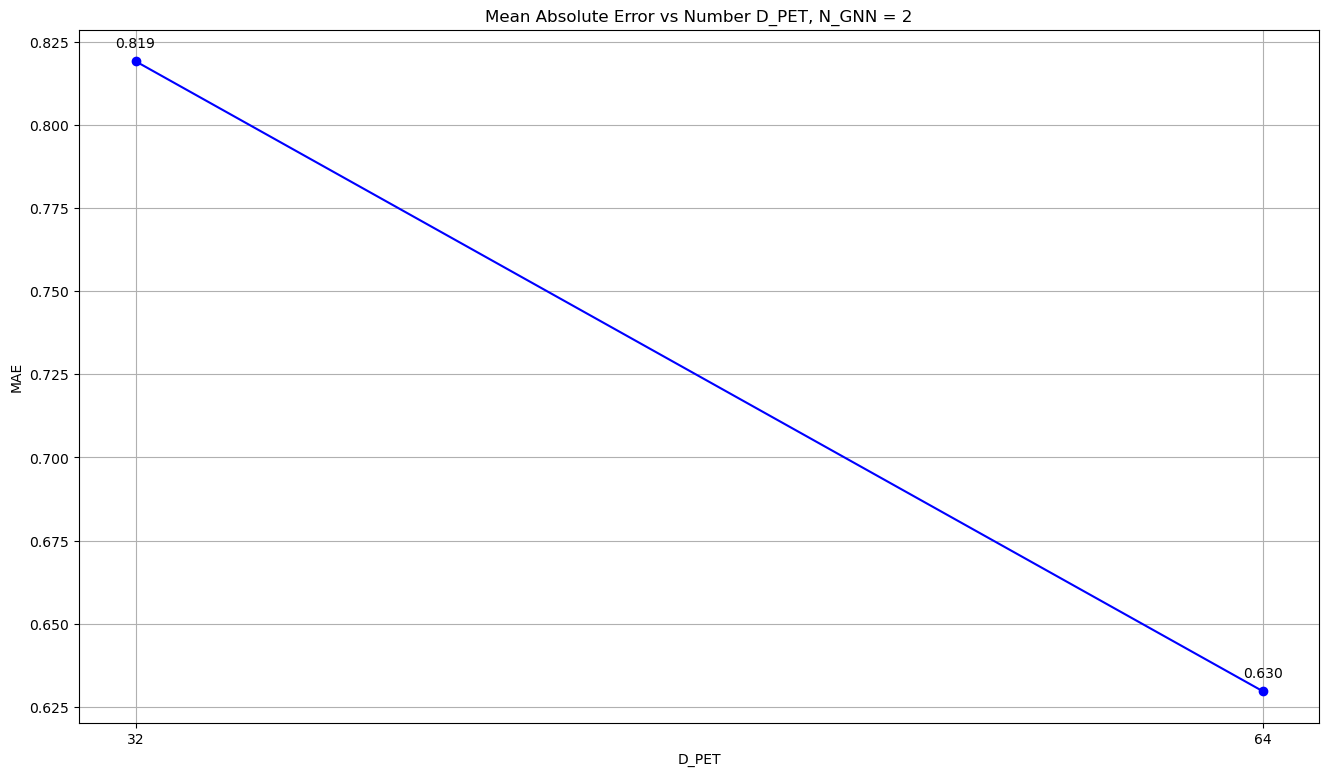

In [82]:
FOLDERS = ["run_2_32", "run_2_64"]
D_PET = [32, 64]

best_maes = get_best_maes(folders=FOLDERS, keys=D_PET)

x_values = list(best_maes.keys())
y_values = list(best_maes.values())

plot(
    x_values,
    y_values,
    title="Mean Absolute Error vs Number D_PET, N_GNN = 2",
    xlabel="D_PET",
    ylabel="MAE",
)

### Interference Times

Finally, we analyze the interference times from the output of running fitted PET models on the test structures. 

In [83]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128", "run_2_32", "run_2_64", "run_3_32"]
KEYS = [
    "N_GNN 1, D_PET 32",
    "N_GNN 1, D_PET 64",
    "N_GNN 1, D_PET 128",
    "N_GNN 2, D_PET 32",
    "N_GNN 2, D_PET 64",
    "N_GNN 3, D_PET 32",
]

target_phrase = "approximate time per atom "

interference_times = {}

for index, folder in enumerate(FOLDERS):
    test_file_path = os.path.join(folder, "test.txt")

    if not os.path.isfile(test_file_path):
        print(f"File {test_file_path} not found")
        continue

    with open(test_file_path, "r") as file:
        for line in file:
            if target_phrase in line:
                interference_times[KEYS[index]] = float(line.split()[-2].strip())

In [84]:
interference_times

{'N_GNN 1, D_PET 32': 1.1136775044512621e-05,
 'N_GNN 1, D_PET 64': 1.3557845768149893e-05,
 'N_GNN 1, D_PET 128': 1.720539880414244e-05,
 'N_GNN 2, D_PET 32': 2.0005139760428476e-05,
 'N_GNN 2, D_PET 64': 2.4157245362541106e-05,
 'N_GNN 3, D_PET 32': 2.8972569826177796e-05}

In [85]:
x_values = list(get_best_maes(FOLDERS, KEYS).values())
y_values = list(interference_times.values())

In [86]:
paired_values = list(zip(x_values, y_values))
paired_values.sort()

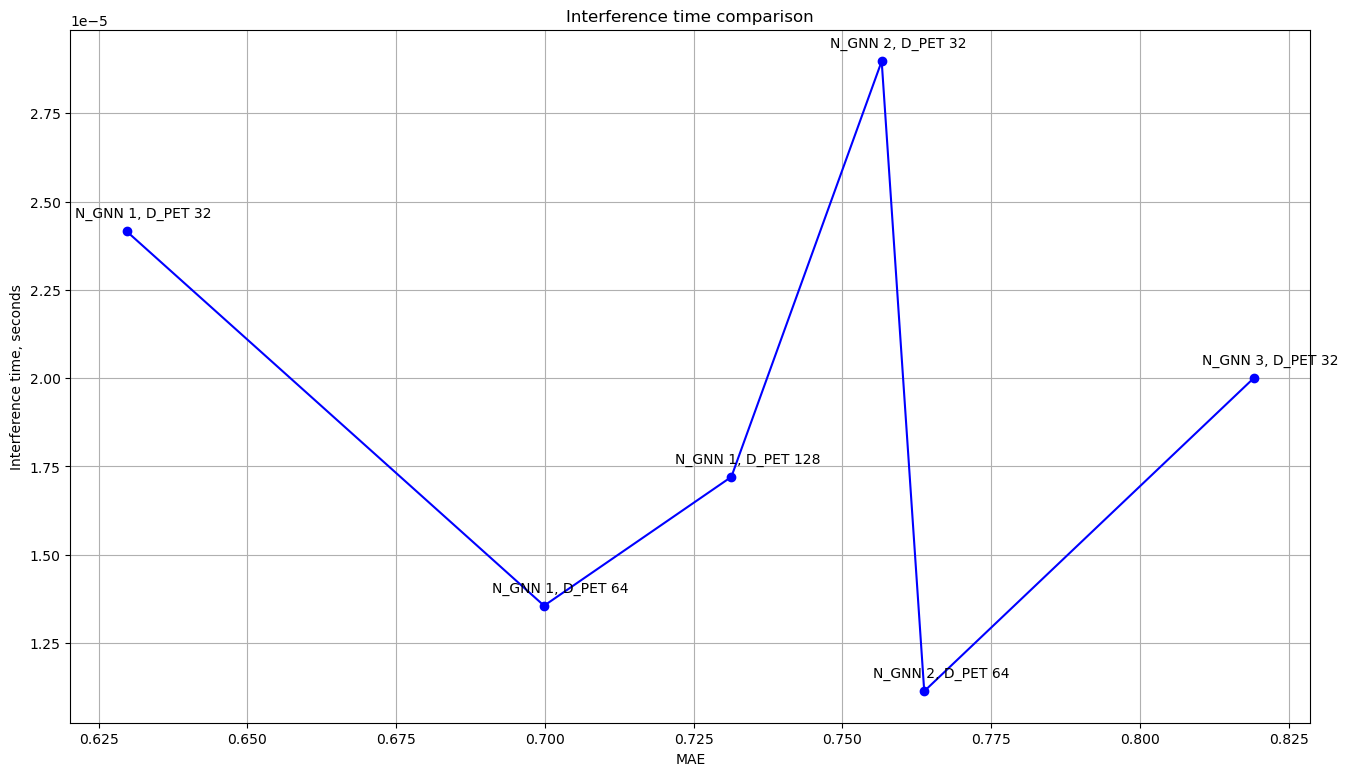

In [87]:
x_values_sorted, y_values_sorted = zip(*paired_values)

plt.figure(figsize=(16, 9))
plt.title("Interference time comparison")
plt.ylabel("Interference time, seconds")
plt.xlabel("MAE")
plt.plot(x_values_sorted, y_values_sorted, "bo-")

for index, (x, y) in enumerate(zip(list(x_values_sorted), list(y_values_sorted))):
    plt.annotate(
        f"{KEYS[index]}",
        (x, y),
        textcoords="offset points",
        xytext=(12, 10),
        ha="center",
    )

plt.grid(True)
plt.show()

### Learning Rates

In [88]:
def get_smooth(values, gamma):
    smoothed = []
    for i in range(len(values)):
        if i == 0:
            smoothed.append(values[i])
        else:
            smoothed.append(gamma * values[i] + (1 - gamma) * smoothed[i - 1])
    return smoothed

In [89]:
def present(ax, files, key, energy_key="energy"):
    ax.set_ylabel("mae")
    ax.set_xlabel("epoch")
    ax.set_title(key)

    for file in files:
        # Load history.pickle
        if not os.path.exists(f"{file}/history.pickle"):
            print(f"File {file}/history.pickle does not exist.")
            continue

        with open(f"{file}/history.pickle", "rb") as f:
            data = pickle.load(f)

        # Load continuation data
        i = 0
        while os.path.isdir(f"{file}_continuation_{i}"):
            continuation_path = f"{file}_continuation_{i}/history.pickle"
            if os.path.exists(continuation_path):
                with open(continuation_path, "rb") as f:
                    continuation_data = pickle.load(f)
                data.extend(continuation_data)
                i += 1
            else:
                break

        # Get data
        grid, val_mae, train_mae = [], [], []
        for idx, el in enumerate(data):
            grid.append(idx)
            val_mae.append(el[energy_key]["val"]["mae"])
            train_mae.append(el[energy_key]["train"]["mae"])

        smooth_val = get_smooth(val_mae, 0.7)
        smooth_train = get_smooth(train_mae, 0.7)

        # Statistics
        print()
        print(file)
        print("val min: ", np.min(val_mae))
        print("smooth val min: ", np.min(smooth_val))
        print("val last 500: ", np.mean(val_mae[-500:]))
        print("best val pos: ", np.argmin(val_mae) / len(val_mae))
        print("train min: ", np.min(train_mae))
        print("smooth train min: ", np.min(smooth_train))

        # Plots
        ax.plot(grid, smooth_val, label=f"val {np.min(val_mae):.2e}")
        ax.plot(grid, smooth_train, label=f"train {smooth_train[-1]:.2e}")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.grid(True)

['./run_1_32/results/test']

./run_1_32/results/test
val min:  0.7637514041535808
smooth val min:  0.7671837309121281
val last 500:  0.799403212862933
best val pos:  0.9729230769230769
train min:  0.19678355753261415
smooth train min:  0.19851420534793984
['./run_1_64/results/test']

./run_1_64/results/test
val min:  0.6998528671108901
smooth val min:  0.7036313243775006
val last 500:  0.718659899231905
best val pos:  0.5139372822299652
train min:  0.05606159051087173
smooth train min:  0.05683702190772946
['./run_1_128/results/test']

./run_1_128/results/test
val min:  0.7313318520832528
smooth val min:  0.7342617261520112
val last 500:  0.7538404453972335
best val pos:  0.585675430643699
train min:  0.048468517124986996
smooth train min:  0.04968218466002033
['./run_2_32/results/test']

./run_2_32/results/test
val min:  0.8191660488327988
smooth val min:  0.8283356410105184
val last 500:  0.9105409540666272
best val pos:  0.998220640569395
train min:  0.20492597102810983
smooth train

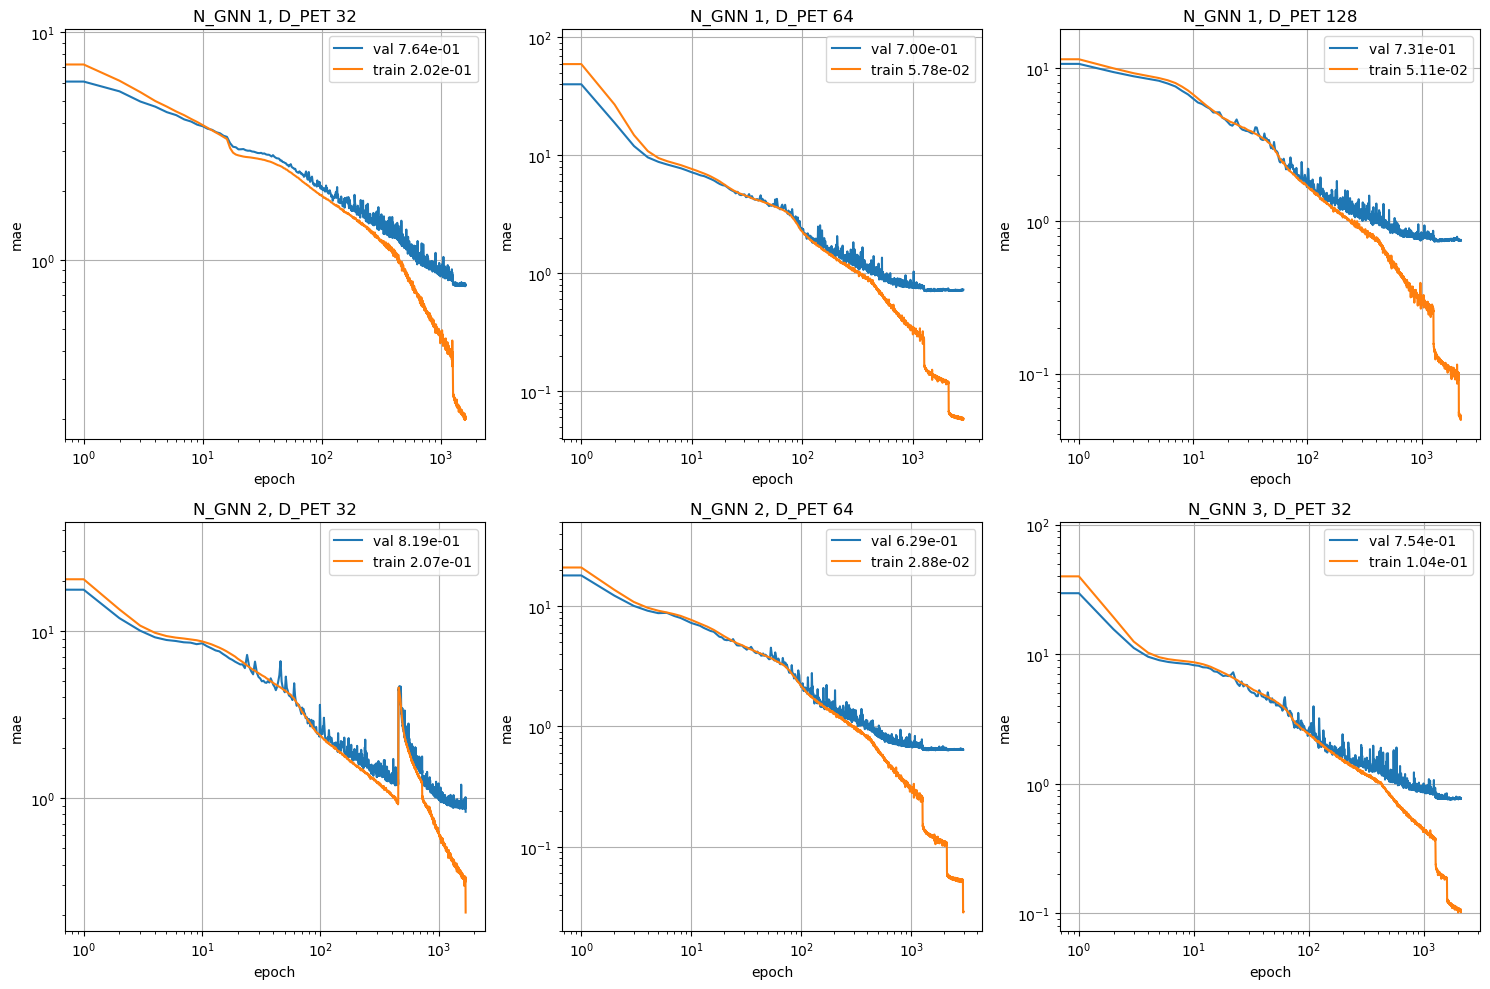

In [90]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128", "run_2_32", "run_2_64", "run_3_32"]
KEYS = [
    "N_GNN 1, D_PET 32",
    "N_GNN 1, D_PET 64",
    "N_GNN 1, D_PET 128",
    "N_GNN 2, D_PET 32",
    "N_GNN 2, D_PET 64",
    "N_GNN 3, D_PET 32",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, folder, key in zip(axes, FOLDERS, KEYS):
    FOLDER_PATH = f"./{folder}/results/"

    files = os.listdir(FOLDER_PATH)

    files = [FOLDER_PATH + file for file in files if not file.startswith(".")]
    files = [file for file in files if "continuation" not in file]
    print(files)

    present(ax, files, key, energy_key="energies per structure")

plt.tight_layout()
plt.show()